### Import Data

In [1]:
# paths
ROOT_DIR = "caverlee-2011/social_honeypot_icwsm_2011/"

In [2]:
# read data
import pandas as pd

ham_users = pd.read_csv(ROOT_DIR + "legitimate_users.txt",
                         sep='\t',
                         names = ['UserID',
                                  'CreatedAt',
                                  'CollectedAt',
                                  'NumberOfFollowings',
                                  'NumberOfFollowers',
                                  'NumberOfTweets',
                                  'LengthOfScreenName',
                                  'LengthOfDescriptionInUserProfile'])
ham_tweets = pd.read_csv(ROOT_DIR + "legitimate_users_tweets.txt",
                        sep='\t',
                        names = ['UserID',
                                'TweetID',
                                'Tweet',
                                'CreatedAt'],
                        quoting=3)

ham_followings = pd.read_csv(ROOT_DIR + "legitimate_users_followings.txt",
                             sep='\t',
                             names = ['UserID',
                                      'SeriesOfNumberOfFollowings'])


spam_users = pd.read_csv(ROOT_DIR + "content_polluters.txt",
                         sep='\t',
                         names = ['UserID',
                                  'CreatedAt',
                                  'CollectedAt',
                                  'NumberOfFollowings',
                                  'NumberOfFollowers',
                                  'NumberOfTweets',
                                  'LengthOfScreenName',
                                  'LengthOfDescriptionInUserProfile'])
spam_tweets = pd.read_csv(ROOT_DIR + "content_polluters_tweets.txt",
                          sep='\t',
                          names = ['UserID',
                                   'TweetID',
                                   'Tweet',
                                   'CreatedAt'],
                         quoting=3)
spam_followings = pd.read_csv(ROOT_DIR + "content_polluters_followings.txt",
                              sep='\t',
                              names = ['UserID',
                                       'SeriesOfNumberOfFollowings'])
       

In [3]:
# Debugging
# display(ham_users)
# display(ham_tweets)
# display(ham_followings)
# display(spam_users)
# display(spam_tweets)
# display(spam_followings)

### Get Hashtags

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import re

ham_users_input = pd.read_csv('data/ham_features.csv')
spam_users_input = pd.read_csv('data/spam_features.csv')

def extract_hashtags(tweet):
    return re.findall(r'#([A-Za-z][A-Za-z0-9]*)', str(tweet))

spam_tweets['Hashtags'] = spam_tweets['Tweet'].apply(lambda x: extract_hashtags(x))
spam_tweets['HashtagCount'] = spam_tweets['Tweet'].apply(lambda x: len(extract_hashtags(x)))
spam_tweets['UniqueHashtags'] = spam_tweets['Tweet'].apply(lambda x: set(extract_hashtags(x)))
ham_tweets['Hashtags'] = ham_tweets['Tweet'].apply(lambda x: extract_hashtags(x))
ham_tweets['HashtagCount'] = ham_tweets['Tweet'].apply(lambda x: len(set(extract_hashtags(x))))
ham_tweets['UniqueHashtags'] = ham_tweets['Tweet'].apply(lambda x: set(extract_hashtags(x)))
display(spam_tweets.sort_values(by='HashtagCount', ascending=False))

,UserID,TweetID,Tweet,CreatedAt,Hashtags,HashtagCount,UniqueHashtags
608682,40130106,17661910652,#ger#ger#ger#ger#ger#ger#ger#ger#ger#ger#ger#g...,2010-07-03 11:34:48,"[ger, ger, ger, ger, ger, ger, ger, ger, ger, ...",35,{ger}
608730,40130106,17962660794,#ger#ger#ger#ger#ger#ger#ger#ger#ger#ger#ger#g...,2010-07-07 11:46:02,"[ger, ger, ger, ger, ger, ger, ger, ger, ger, ...",35,{ger}
832413,57608714,16066163685,#GER #GER #GER #GER #GER #GER #GER #GER #GER #...,2010-06-13 06:37:36,"[GER, GER, GER, GER, GER, GER, GER, GER, GER, ...",28,{GER}
805344,55710866,17036228925,#esp #esp #esp #esp #esp #esp #esp #esp #esp #...,2010-06-25 13:55:10,"[esp, esp, esp, esp, esp, esp, esp, esp, esp, ...",28,{esp}
832466,57608714,16871354466,#GER #GER #GER #GER #GER #GER #GER #GER #GER #...,2010-06-23 14:24:11,"[GER, GER, GER, GER, GER, GER, GER, GER, GER, ...",27,{GER}
...,...,...,...,...,...,...,...
827555,57246997,5755743971,New Blog Post: Get A Payday Loan Today http://...,2009-11-15 21:52:23,[],0,{}
827554,57246997,5755679468,New Blog Post: Why Get A Same Day Payday Loan?...,2009-11-15 21:49:28,[],0,{}
827553,57246997,5755633816,New Blog Post: A Faxless Payday Loan Is Fast A...,2009-11-15 21:47:20,[],0,{}
827552,57246997,5704853971,Don't miss the chance to win $500 per week by ...,2009-11-14 02:16:17,[],0,{}


In [6]:
def merge_sets(sets):
    return set.union(*sets)

ham_tweet_counts = ham_tweets.groupby('UserID').size().reset_index()
ham_tweet_counts.columns = ['UserID','RecordedTweetCount']
ham_users = pd.merge(ham_users, ham_tweet_counts, on='UserID', how='left')
display(ham_users)

spam_tweet_counts = spam_tweets.groupby('UserID').size().reset_index()
spam_tweet_counts.columns = ['UserID','RecordedTweetCount']
spam_users = pd.merge(spam_users, spam_tweet_counts, on='UserID', how='left')

,UserID,CreatedAt,CollectedAt,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,LengthOfScreenName,LengthOfDescriptionInUserProfile,RecordedTweetCount
0,614,2006-07-13 15:30:05,2009-11-20 23:56:21,510,350,3265,10,34,200.0
1,1038,2006-07-15 16:12:15,2009-11-16 05:12:11,304,443,4405,7,156,200.0
2,1437,2006-07-16 12:29:24,2009-11-16 16:25:12,45,73,725,6,37,200.0
3,2615,2006-07-19 23:23:55,2009-11-27 18:34:36,211,230,211,7,0,200.0
4,3148,2006-07-26 14:17:22,2009-11-20 17:35:18,7346,7244,11438,8,97,199.0
...,...,...,...,...,...,...,...,...,...
19271,93390990,2009-11-29 06:34:30,2009-11-29 07:50:54,5,0,5,11,0,5.0
19272,93402679,2009-11-29 07:47:50,2009-11-29 07:56:28,20,1,1,12,0,1.0
19273,93419256,2009-11-29 09:23:30,2009-11-29 09:30:48,0,0,1,8,0,1.0
19274,93426370,2009-11-29 10:04:26,2009-11-29 10:13:17,20,1,1,10,0,1.0


In [7]:
# Grouping by 'UserID' and counting tweets with at least one hashtag
ham_hashtag_count = ham_tweets.groupby('UserID')['HashtagCount'].apply(lambda x: (x > 0).sum()).reset_index()
ham_hashtag_count.columns = ['UserID', 'TweetsWithHashtagsCount']
ham_hashtag_count['TweetsWithHashtagsCount'] = ham_hashtag_count['TweetsWithHashtagsCount'].astype(int)

ham_users_input['HashtagTweetsCount'] = ham_hashtag_count['TweetsWithHashtagsCount']
ham_users_input['HashtagTweetsCount'] = ham_users_input['HashtagTweetsCount'].replace([np.inf, -np.inf], np.nan).fillna(0)

spam_hashtag_count = spam_tweets.groupby('UserID')['HashtagCount'].apply(lambda x: (x > 0).sum()).reset_index()
spam_hashtag_count.columns = ['UserID', 'TweetsWithHashtagsCount']
spam_hashtag_count['TweetsWithHashtagsCount'] = spam_hashtag_count['TweetsWithHashtagsCount'].astype(int)

spam_users_input['HashtagTweetsCount'] = spam_hashtag_count['TweetsWithHashtagsCount']
spam_users_input['HashtagTweetsCount'] = spam_users_input['HashtagTweetsCount'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [8]:
ham_sum_hashtags = ham_tweets.groupby('UserID')['HashtagCount'].sum().reset_index()
ham_sum_hashtags.columns = ['UserID','HashtagSum']
# add mention average to features
ham_users_input['HashtagAverage'] = ham_sum_hashtags['HashtagSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['HashtagAverage'] = ham_users_input['HashtagAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

ham_unique_hashtags = ham_tweets.groupby('UserID')['UniqueHashtags'].agg(merge_sets).reset_index()
ham_unique_hashtags.columns = ['UserID','UniqueHashtags']
ham_unique_hashtags['UniqueHashtagSum'] = ham_unique_hashtags['UniqueHashtags'].apply(lambda x: len(x))
# add unique mention average to features
ham_users_input['UniqueHashtagAverage'] = ham_unique_hashtags['UniqueHashtagSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['UniqueHashtagAverage'] = ham_users_input['UniqueHashtagAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [9]:
spam_sum_hashtags = spam_tweets.groupby('UserID')['HashtagCount'].sum().reset_index()
spam_sum_hashtags.columns = ['UserID','HashtagSum']
# add mention average to features
spam_users_input['HashtagAverage'] = spam_sum_hashtags['HashtagSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['HashtagAverage'] = spam_users_input['HashtagAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

spam_unique_hashtags = spam_tweets.groupby('UserID')['UniqueHashtags'].agg(merge_sets).reset_index()
spam_unique_hashtags.columns = ['UserID','UniqueHashtags']
spam_unique_hashtags['UniqueHashtagSum'] = spam_unique_hashtags['UniqueHashtags'].apply(lambda x: len(x))
# add unique mention average to features
spam_users_input['UniqueHashtagAverage'] = spam_unique_hashtags['UniqueHashtagSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['UniqueHashtagAverage'] = spam_users_input['UniqueHashtagAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [10]:
display(spam_users_input)

,UserID,LengthOfScreenName,LengthOfDescriptionInUserProfile,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,Longevity,FollowRatio,TweetsPerDay,LinkAverage,UniqueLinkAverage,MentionAverage,UniqueMentionAverage,Compression_Ratio,FollowingChangeRate,label,Similarity,HashtagTweetsCount,HashtagAverage,UniqueHashtagAverage
0,6301,8,132,3269,3071,861,1217,1.064474,0.707477,0.705000,0.125000,0.335000,0.220000,2.906114,5.880914,1,0.025665,8.0,0.090000,0.065000
1,10836,9,134,1949,793,226,1329,2.457755,0.170053,0.656566,0.185000,0.272727,0.065657,3.439276,1.176554,1,0.020403,64.0,0.510101,0.030303
2,10997,12,158,1119,9644,38674,1272,0.116031,30.404088,0.269036,0.065000,0.553299,0.253807,2.672691,9.000000,1,0.029878,33.0,0.659898,0.538071
3,633293,11,121,2174,6029,12718,1105,0.360590,11.509502,0.320000,0.085000,0.445000,0.250000,2.609804,7.056850,1,0.018902,18.0,0.095000,0.090000
4,717883,6,70,7731,7029,873,1105,1.099872,0.790045,0.690000,0.045226,0.105000,0.025000,2.630435,3.138019,1,0.054825,2.0,0.010000,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22218,173715049,12,0,63,10,29,0,6.300000,0.000000,0.000000,0.000000,0.000000,0.000000,6.968932,6.952218,1,0.071755,0.0,0.000000,0.000000
22219,173718053,8,0,83,10,35,0,8.300000,0.000000,0.000000,0.000000,0.000000,0.000000,7.165837,6.082763,1,0.070237,0.0,0.000000,0.000000
22220,173721018,13,0,67,9,21,0,7.444444,0.000000,0.000000,0.000000,0.000000,0.000000,5.409938,6.480741,1,0.038650,0.0,0.000000,0.000000
22221,173723395,12,0,35,4,17,0,8.750000,0.000000,0.000000,0.000000,0.000000,0.000000,5.170316,6.757712,1,0.060997,0.0,0.000000,0.000000


#### Total Number of Hashtags

In [11]:
spam_counts = spam_tweets['HashtagCount'].value_counts(normalize=True)
spam_cumsum = spam_counts.cumsum() * 100
spam_cumsum = spam_cumsum[spam_cumsum.index <= 10]

ham_counts = ham_tweets['HashtagCount'].value_counts(normalize=True)
ham_cumsum = ham_counts.cumsum() * 100
ham_cumsum = ham_cumsum[ham_cumsum.index <= 10]

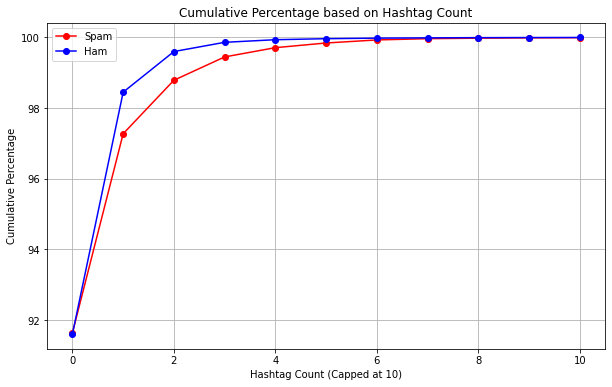

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(spam_cumsum.index, spam_cumsum.values, marker='o', linestyle='-', color='red', label='Spam')
plt.plot(ham_cumsum.index, ham_cumsum.values, marker='o', linestyle='-', color='blue', label='Ham')
plt.xlabel('Hashtag Count (Capped at 10)')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Percentage based on Hashtag Count')
plt.grid(True)
plt.legend()
plt.show()

#### Number of Words in Hashtag

In [13]:
import wordsegment
from wordsegment import load, segment

# Assuming 'ham_tweets' is your DataFrame

# Initialize 'AverageWordsInHashtag' column with zeros
ham_tweets['AverageCharactersInHashtag'] = 0
ham_tweets['AverageWordsInHashtag'] = 0

# Load wordsegment
load()

# Calculate average words in hashtag for rows with at least one hashtag
hashtag_rows = ham_tweets[ham_tweets['HashtagCount'] > 0]
hashtag_rows['AverageCharactersInHashtag'] = hashtag_rows['Hashtags'].apply(lambda x: sum(len(tag) for tag in x) / len(x) if len(x) > 0 else 0)
hashtag_rows['AverageWordsInHashtag'] = hashtag_rows['Hashtags'].apply(
    lambda hashtags: sum(len(segment(hashtag)) for hashtag in hashtags) / len(hashtags)
)

# Update 'AverageWordsInHashtag' column in the original DataFrame
ham_tweets.update(hashtag_rows)

# Display the updated DataFrame
display(ham_tweets)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,UserID,TweetID,Tweet,CreatedAt,Hashtags,HashtagCount,UniqueHashtags,AverageCharactersInHashtag,AverageWordsInHashtag
0,614.0,5.912305e+09,… at house party in Daybreak. Not as weird as ...,2009-11-20 23:52:52,[],0.0,{},0.0,0.0
1,614.0,5.908467e+09,Taxiing — at SLC Salt Lake City International...,2009-11-20 20:42:48,[],0.0,{},0.0,0.0
2,614.0,5.904902e+09,Almost home! — at PDX Portland International ...,2009-11-20 18:11:01,[],0.0,{},0.0,0.0
3,614.0,5.900352e+09,Lunch! — at Ten01 http://gowal.la/s/Awa,2009-11-20 15:04:42,[],0.0,{},0.0,0.0
4,614.0,5.900313e+09,Mm … books — at @Powells http://gowal.la/s/6fe,2009-11-20 15:03:06,[],0.0,{},0.0,0.0
...,...,...,...,...,...,...,...,...,...
3259688,93390990.0,6.168916e+09,meet me on ELIMINATE pro!!,2009-11-29 06:44:03,[],0.0,{},0.0,0.0
3259689,93402679.0,6.170059e+09,my twitter,2009-11-29 07:52:22,[],0.0,{},0.0,0.0
3259690,93419256.0,6.171947e+09,exploring this thing...,2009-11-29 09:25:53,[],0.0,{},0.0,0.0
3259691,93426370.0,6.172856e+09,"learning the rap ice ice baby LOL, not very gd...",2009-11-29 10:08:09,[],0.0,{},0.0,0.0


In [14]:
display(ham_tweets[ham_tweets['HashtagCount'] >= 10].sort_values('AverageCharactersInHashtag', ascending=False).head(10))

,UserID,TweetID,Tweet,CreatedAt,Hashtags,HashtagCount,UniqueHashtags,AverageCharactersInHashtag,AverageWordsInHashtag
2650941,67515018.0,5.880114e+09,#fuckrich #teambvegz #pillsrbad #qurl #freewee...,2009-11-19 22:26:30,"[fuckrich, teambvegz, pillsrbad, qurl, freewee...",11.0,"{moneyindabank, freeweezy, teambvegz, fuckeric...",9.818182,2.545455
446889,16528735.0,6.156800e+09,#vidly #powermat #syncmyridepodcast #vidly #Gi...,2009-11-28 19:24:36,"[vidly, powermat, syncmyridepodcast, vidly, Gi...",11.0,"{powermat, ChristmasWreath, syncmyridepodcast,...",8.833333,2.250000
446845,16528735.0,6.159396e+09,I want to win free #TOYs @FamilyFun! #Give10 #...,2009-11-28 21:15:03,"[TOYs, Give10, vidly, shopcybermonday, KmartBL...",10.0,"{powermat, christmaswreath, TOYs, shopcybermon...",8.400000,2.000000
569475,18002030.0,6.060868e+09,#Give10 #shopcybermonday #im_a_shred_head #PDC...,2009-11-25 14:58:27,"[Give10, shopcybermonday, im, PDC09, eklipse, ...",12.0,"{powermat, rummikubiphone, runwaygiveaway, Kma...",8.000000,2.083333
2967729,78713799.0,5.068015e+09,A few items we offer at #Artfire.com & #Ioffer...,2009-10-22 07:32:58,"[Artfire, Ioffer, Glycerin, CitricAcid, Caffei...",10.0,"{EDTA, Glycerin, DendriticSalt, Decyl, Carnaub...",7.600000,1.400000
825271,21319497.0,4.713117e+09,http://tinyurl.com/l42ajd Another painting #ab...,2009-10-08 12:54:13,"[abstractart, painting, art, abstractpainting,...",10.0,"{mexico, pintor, arte, pintura, painting, art,...",7.400000,1.300000
1777304,41982985.0,4.794771e+09,http://bit.ly/Np4II <-- need your opinion #fin...,2009-10-11 18:00:11,"[finalcut, apple, editing, HD1080i, film, film...",11.0,"{production, video, HD1080i, finalcut, apple, ...",6.909091,1.090909
1777311,41982985.0,4.790779e+09,http://bit.ly/Np4II Latino Heritage Month #lat...,2009-10-11 14:38:36,"[latinos, spanish, espa, peliculas, cine, inmi...",11.0,"{latism, spanish, espa, cine, EEUU, peliculas,...",6.727273,1.363636
2441947,60969714.0,5.401254e+09,"update da horta: #alecrim, #gengibre, #alho, #...",2009-11-03 14:50:16,"[alecrim, gengibre, alho, alfazema, espinafre,...",11.0,"{mel, berinjela, espinafre, alecrim, pepino, a...",6.727273,2.272727
437401,16419377.0,5.446504e+09,blog's keywords are #instala #acrobat #ubuntu ...,2009-11-05 04:32:46,"[instala, acrobat, ubuntu, gloobus, editor, vi...",11.0,"{video, editor, ubuntu, pilitos, instala, gloo...",6.727273,1.272727


In [15]:
spam_tweets['AverageCharactersInHashtag'] = 0
spam_tweets['AverageWordsInHashtag'] = 0

load()
hashtag_rows = spam_tweets[spam_tweets['HashtagCount'] > 0]
hashtag_rows['AverageCharactersInHashtag'] = hashtag_rows['Hashtags'].apply(lambda x: sum(len(tag) for tag in x) / len(x) if len(x) > 0 else 0)
hashtag_rows['AverageWordsInHashtag'] = hashtag_rows['Hashtags'].apply(
    lambda hashtags: sum(len(segment(hashtag)) for hashtag in hashtags) / len(hashtags)
)

spam_tweets.update(hashtag_rows)
display(spam_tweets[spam_tweets['HashtagCount'] >= 10].sort_values('AverageCharactersInHashtag', ascending=False).head(10))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,UserID,TweetID,Tweet,CreatedAt,Hashtags,HashtagCount,UniqueHashtags,AverageCharactersInHashtag,AverageWordsInHashtag
488531,30705094.0,7.729451e+09,#Businesspark #Commercialrealestate #CassidyRe...,2010-01-13 19:04:48,"[Businesspark, Commercialrealestate, CassidyRe...",10.0,"{CassidyRebrandings, Economics, Businesspark, ...",11.900000,2.000000
488505,30705094.0,7.708799e+09,#Homeprices #Spokenarticles #Businesslaw #USAc...,2010-01-13 08:01:49,"[Homeprices, Spokenarticles, Businesslaw, USAc...",10.0,"{Spokenarticles, Realestate, USAcentric, Manag...",11.800000,2.000000
1308888,89367529.0,8.293999e+09,#whodoesthat #whodoesthat #whodoesthat #whodoe...,2010-01-27 14:55:48,"[whodoesthat, whodoesthat, whodoesthat, whodoe...",10.0,{whodoesthat},11.000000,3.000000
2268372,148981864.0,1.492800e+10,#BETComedian #BETComedian #BETComedian #BETCom...,2010-05-28 14:40:41,"[BETComedian, BETComedian, BETComedian, BETCom...",10.0,{BETComedian},11.000000,2.000000
488595,30705094.0,7.790158e+09,#DottieHermanread #DianeRamirezread #VanNessMi...,2010-01-15 09:02:04,"[DottieHermanread, DianeRamirezread, VanNessMi...",11.0,"{Wifi, Debt, Management, DottieHermanread, Van...",10.636364,1.818182
462844,28927143.0,1.237311e+10,RT @MHEAT: #LETSGOHEAT #BLACKisBACK #LETSGOHEA...,2010-04-17 21:02:14,"[LETSGOHEAT, BLACKisBACK, LETSGOHEAT, BLACKisB...",10.0,"{BLACKisBACK, LETSGOHEAT}",10.500000,3.000000
862349,59790816.0,1.005578e+10,#ferreiraera #ferreiraera #ferreiraera #ferrei...,2010-03-05 20:59:19,"[ferreiraera, ferreiraera, ferreiraera, ferrei...",11.0,"{ferreiraera, tt}",10.181818,1.909091
488651,30705094.0,7.870426e+09,#MaxVentillaread #Minn #Ill #Wreckingball #Jan...,2010-01-17 11:41:19,"[MaxVentillaread, Minn, Ill, Wreckingball, Jan...",11.0,"{Featuredarticles, Wreckingball, TimR, Financi...",10.181818,1.909091
862347,59790816.0,1.005568e+10,#ferreiraera #ferreiraera #ferreiraera #ferrei...,2010-03-05 20:56:43,"[ferreiraera, ferreiraera, ferreiraera, ferrei...",11.0,"{ferreiraera, tt}",10.181818,1.909091
589515,38641441.0,1.547540e+10,#VanZieonPT #VanZieonPT #VanZieonPT #VanZieonP...,2010-06-05 03:22:28,"[VanZieonPT, VanZieonPT, VanZieonPT, VanZieonP...",10.0,{VanZieonPT},10.000000,4.000000


In [16]:
average_words_ham_group = ham_tweets.groupby('UserID')['AverageCharactersInHashtag'].sum().reset_index()
ham_users_input['AverageCharactersInHashtag'] = average_words_ham_group['AverageCharactersInHashtag'] / ham_users_input['HashtagTweetsCount']
ham_users_input['AverageCharactersInHashtag'] = ham_users_input['AverageCharactersInHashtag'].replace([np.inf, -np.inf], np.nan).fillna(0)

average_words_spam_group = spam_tweets.groupby('UserID')['AverageCharactersInHashtag'].sum().reset_index()
spam_users_input['AverageCharactersInHashtag'] = average_words_spam_group['AverageCharactersInHashtag'] / spam_users_input['HashtagTweetsCount']
spam_users_input['AverageCharactersInHashtag'] = spam_users_input['AverageCharactersInHashtag'].replace([np.inf, -np.inf], np.nan).fillna(0)

average_words_ham_group = ham_tweets.groupby('UserID')['AverageWordsInHashtag'].sum().reset_index()
ham_users_input['AverageWordsInHashtag'] = average_words_ham_group['AverageWordsInHashtag'] / ham_users_input['HashtagTweetsCount']
ham_users_input['AverageWordsInHashtag'] = ham_users_input['AverageWordsInHashtag'].replace([np.inf, -np.inf], np.nan).fillna(0)

average_words_spam_group = spam_tweets.groupby('UserID')['AverageWordsInHashtag'].sum().reset_index()
spam_users_input['AverageWordsInHashtag'] = average_words_spam_group['AverageWordsInHashtag'] / spam_users_input['HashtagTweetsCount']
spam_users_input['AverageWordsInHashtag'] = spam_users_input['AverageWordsInHashtag'].replace([np.inf, -np.inf], np.nan).fillna(0)

display(spam_users_input.sort_values('AverageCharactersInHashtag', ascending=False))

,UserID,LengthOfScreenName,LengthOfDescriptionInUserProfile,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,Longevity,FollowRatio,TweetsPerDay,LinkAverage,...,UniqueMentionAverage,Compression_Ratio,FollowingChangeRate,label,Similarity,HashtagTweetsCount,HashtagAverage,UniqueHashtagAverage,AverageCharactersInHashtag,AverageWordsInHashtag
19478,140056928,11,110,623,68,96,26,9.161765,3.692308,1.247423,...,0.020619,2.693916,6.796699,1,0.024191,1.0,0.010309,0.010309,53.000000,6.000000
7692,79192826,12,70,3924,3576,2906,167,1.097315,17.401198,0.710000,...,0.000000,2.987474,2.806729,1,0.043644,137.0,0.720000,0.010000,39.054745,9.770073
17398,126901476,14,127,1996,185,278,7,10.789189,39.714286,0.005000,...,0.180000,2.734104,1.043185,1,0.076039,1.0,0.005000,0.005000,30.000000,5.000000
18840,136454936,14,138,776,103,59,1,7.533981,59.000000,0.101695,...,0.016949,5.042391,6.222231,1,0.145018,1.0,0.016949,0.016949,26.000000,5.000000
6669,70168046,8,119,186,36,4,312,5.166667,0.012821,10.200000,...,9.600000,2.184564,1.013016,1,0.013155,1.0,0.200000,0.200000,26.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12147,102504645,10,0,1310,267,17,12,4.906367,1.416667,0.705882,...,0.058824,4.540598,2.018474,1,0.201689,0.0,0.000000,0.000000,0.000000,0.000000
4122,43857535,9,22,823,385,134,250,2.137662,0.536000,0.435115,...,0.534351,2.728516,4.940254,1,0.021794,0.0,0.000000,0.000000,0.000000,0.000000
12149,102510096,7,156,955,531,289,12,1.798493,24.083333,0.875000,...,0.050000,4.019830,2.044270,1,0.160519,0.0,0.000000,0.000000,0.000000,0.000000
12150,102517637,12,79,847,277,85,26,3.057762,3.269231,0.647059,...,0.400000,3.114286,1.912953,1,0.100784,0.0,0.000000,0.000000,0.000000,0.000000


In [17]:
# Fun little find, this gotta be one of the most 2009 things I've ever read
print(ham_tweets.iloc[2071078]['Tweet'])

RT @BigEazy17: #ifyoucanreadthistweetyouhavebeenontwittertoofuckinlongbutdontworryyouarenotalonelikemichaeljackson


[0.99, 2.0)     63.584047
[2.0, 3.0)      88.434458
[3.0, 4.0)      95.763707
[4.0, 5.0)      98.785491
[5.0, 6.0)      99.691416
[6.0, 7.0)      99.915101
[7.0, 8.0)      99.977123
[8.0, 9.0)      99.994408
[9.0, 10.0)    100.000000
Name: Bins, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


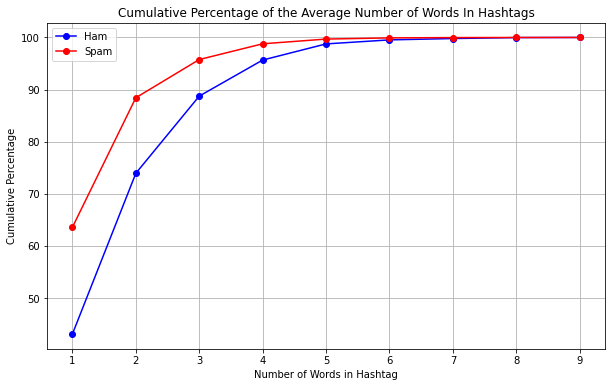

In [18]:
# Cumulative Sum of Average Number of Words in Hashtag, for visualization purposes

bin_edges = [0.99, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Adjust the bin edges as needed

# Use pd.cut() to create bins for 'AverageWordsInHashtag'
ham_tweets_whashtags = ham_tweets[ham_tweets['AverageWordsInHashtag'] > 0]
spam_tweets_whashtags = spam_tweets[spam_tweets['AverageWordsInHashtag'] > 0]
ham_tweets_whashtags['Bins'] = pd.cut(ham_tweets_whashtags['AverageWordsInHashtag'], bins=bin_edges, right=False)
spam_tweets_whashtags['Bins'] = pd.cut(spam_tweets_whashtags['AverageWordsInHashtag'], bins=bin_edges, right=False)

# Calculate cumulative percentage
ham_cumulative_percentages = (
    ham_tweets_whashtags['Bins']
    .value_counts(normalize=True)
    .sort_index()
    .cumsum()
    * 100  # Multiply by 100 to get percentages
)

spam_cumulative_percentages = (
    spam_tweets_whashtags['Bins']
    .value_counts(normalize=True)
    .sort_index()
    .cumsum()
    * 100  # Multiply by 100 to get percentages
)

print(spam_cumulative_percentages)

# Plot the cumulative percentage as a graph
plt.figure(figsize=(10, 6))
ham_cumulative_percentages.plot(kind='line', marker='o', color='blue', label='Ham')
spam_cumulative_percentages.plot(kind='line', marker='o', color='red', label='Spam')
plt.xticks(range(len(bin_edges) - 1), [i for i in range(1, len(bin_edges))])
plt.xlabel('Number of Words in Hashtag')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Percentage of the Average Number of Words In Hashtags')
plt.grid(True)
plt.legend()
plt.show()


In [19]:
all_tweets = pd.concat([ham_tweets[ham_tweets['HashtagCount'] > 0], spam_tweets[spam_tweets['HashtagCount'] > 0]])
all_tweets = all_tweets.reset_index(drop=True)
display(all_tweets)

,UserID,TweetID,Tweet,CreatedAt,Hashtags,HashtagCount,UniqueHashtags,AverageCharactersInHashtag,AverageWordsInHashtag
0,614.0,5.777382e+09,… so it appears that professional networking s...,2009-11-16 16:10:08,[in],1.0,{in},2.0,1.0
1,1038.0,5.760495e+09,Gat in de markt: slow flying. RT @MarcDerby Wi...,2009-11-16 02:35:41,[gewoonrustig],1.0,{gewoonrustig},12.0,3.0
2,1038.0,5.743633e+09,Bijna thuis na een dagje West-Brabant en Zeela...,2009-11-15 13:40:12,[fb],1.0,{fb},2.0,1.0
3,1038.0,5.726505e+09,Top 3 weekly #lastfm artists: Wilco - 18. A...,2009-11-14 21:13:44,[lastfm],1.0,{lastfm},6.0,2.0
4,1038.0,5.707069e+09,Ondersteboven door een brief van Sint en Piet....,2009-11-14 05:30:13,[fb],1.0,{fb},2.0,1.0
...,...,...,...,...,...,...,...,...,...
470558,173323726.0,2.003781e+10,rt @realmarycarey that's cool but Season Two i...,2010-07-31 22:10:04,[trueblood],1.0,{trueblood},9.0,1.0
470559,173323726.0,2.003782e+10,rt @RealKevinNash i tried. says that account'...,2010-07-31 22:10:13,[HBKtwiiter],1.0,{HBKtwiiter},10.0,3.0
470560,173323726.0,2.003783e+10,rt thanks all for those #FF recommendations ye...,2010-07-31 22:10:21,[FF],1.0,{FF},2.0,1.0
470561,173323726.0,2.003784e+10,"rt Yes, I am On the air - if you wanna listen....",2010-07-31 22:10:38,[wreckingballradioshow],1.0,{wreckingballradioshow},21.0,4.0


In [20]:
hashtags_dict = {}
for idx, row in all_tweets.iterrows():
    if idx % 100000 == 0:
        print(idx)
    for hashtag in set(row['UniqueHashtags']):
        hashtag = hashtag.lower()
        if hashtag in hashtags_dict:
            hashtags_dict[hashtag] += 1
        else:
            hashtags_dict[hashtag] = 1
sorted_items = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)
top_values = sorted_items[:10]
top_dict = dict(top_values)
print("TOP 10 ALL:")
for key, value in top_dict.items():
  print(f"{key} ({value} plays)")

0
100000
200000
300000
400000
TOP 10 ALL:
ff (15249 plays)
fb (10068 plays)
quote (9891 plays)
nowplaying (6254 plays)
jobs (6143 plays)
followfriday (5030 plays)
musicmonday (4299 plays)
news (4068 plays)
tcot (3911 plays)
mm (2406 plays)


In [21]:
hashtags_dict = {}
for idx, row in ham_tweets[ham_tweets['HashtagCount'] > 0].iterrows():
    for hashtag in set(row['UniqueHashtags']):
        hashtag = hashtag.lower()
        if hashtag in hashtags_dict:
            hashtags_dict[hashtag] += 1
        else:
            hashtags_dict[hashtag] = 1
sorted_items = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)
top_values = sorted_items[:20]
top_dict_ham = dict(top_values)
print("TOP 20 HAM:")
for key, value in top_dict_ham.items():
  print(f"{key} ({value} plays)")

print("")

hashtags_dict = {}
for idx, row in spam_tweets[spam_tweets['HashtagCount'] > 0].iterrows():
    for hashtag in set(row['UniqueHashtags']):
        hashtag = hashtag.lower()
        if hashtag in hashtags_dict:
            hashtags_dict[hashtag] += 1
        else:
            hashtags_dict[hashtag] = 1
sorted_items = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)
top_values = sorted_items[:20]
top_dict_spam = dict(top_values)
print("TOP 20 SPAM:")
for key, value in top_dict_spam.items():
  print(f"{key} ({value} plays)")

print("")



TOP 20 HAM:
ff (8667 plays)
fb (7668 plays)
jobs (4679 plays)
musicmonday (3111 plays)
tcot (2650 plays)
followfriday (2377 plays)
iranelection (1998 plays)
mm (1927 plays)
fail (1779 plays)
whatsbetter (1597 plays)
justbecause (1415 plays)
tebakbandtranslate (1403 plays)
tinychat (1351 plays)
news (1321 plays)
shjobs (1200 plays)
epicpetwars (1195 plays)
quote (1187 plays)
classicmoviequotes (1159 plays)
theresway2many (1097 plays)
p2 (1002 plays)

TOP 20 SPAM:
quote (8704 plays)
ff (6582 plays)
nowplaying (6069 plays)
news (2747 plays)
followfriday (2653 plays)
fb (2400 plays)
worldcup (1485 plays)
jobs (1464 plays)
free (1321 plays)
nfl (1295 plays)
health (1290 plays)
twitter (1262 plays)
tcot (1261 plays)
business (1198 plays)
marketing (1190 plays)
musicmonday (1188 plays)
iphone (1163 plays)
teamfollowback (1128 plays)
travel (1112 plays)
apple (1101 plays)



In [22]:
ham_keys = list(top_dict_ham.keys())
ham_values = list(top_dict_ham.values())
spam_keys = list(top_dict_spam.keys())
spam_values = list(top_dict_spam.values())
for i in range(len(ham_keys)):
    print(f"{ham_keys[i]}&{ham_values[i]}&{spam_keys[i]}&{spam_values[i]} \\\\")

ff&8667&quote&8704 \\
fb&7668&ff&6582 \\
jobs&4679&nowplaying&6069 \\
musicmonday&3111&news&2747 \\
tcot&2650&followfriday&2653 \\
followfriday&2377&fb&2400 \\
iranelection&1998&worldcup&1485 \\
mm&1927&jobs&1464 \\
fail&1779&free&1321 \\
whatsbetter&1597&nfl&1295 \\
justbecause&1415&health&1290 \\
tebakbandtranslate&1403&twitter&1262 \\
tinychat&1351&tcot&1261 \\
news&1321&business&1198 \\
shjobs&1200&marketing&1190 \\
epicpetwars&1195&musicmonday&1188 \\
quote&1187&iphone&1163 \\
classicmoviequotes&1159&teamfollowback&1128 \\
theresway2many&1097&travel&1112 \\
p2&1002&apple&1101 \\


In [23]:
display(ham_users_input)
display(spam_users_input)

,UserID,LengthOfScreenName,LengthOfDescriptionInUserProfile,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,Longevity,FollowRatio,TweetsPerDay,LinkAverage,...,UniqueMentionAverage,Compression_Ratio,FollowingChangeRate,label,Similarity,HashtagTweetsCount,HashtagAverage,UniqueHashtagAverage,AverageCharactersInHashtag,AverageWordsInHashtag
0,614,10,34,510,350,3265,1226,1.457143,2.663132,0.31000,...,0.310000,2.744422,0.367928,0,0.057874,1.0,0.005000,0.005000,2.000000,1.000000
1,1038,7,156,304,443,4405,1219,0.686230,3.613618,0.27500,...,0.460000,2.516068,0.280362,0,0.018287,28.0,0.165000,0.110000,8.767857,2.267857
2,1437,6,37,45,73,725,1219,0.616438,0.594750,0.09500,...,0.205000,2.455720,0.132164,0,0.019680,35.0,0.220000,0.145000,6.607143,1.435714
3,2615,7,0,211,230,211,1226,0.917391,0.172104,0.13500,...,0.215000,2.630435,0.238262,0,0.020847,2.0,0.010000,0.010000,11.500000,3.000000
4,3148,8,97,7346,7244,11438,1213,1.014081,9.429514,0.58794,...,0.487437,2.635644,0.336953,0,0.020211,18.0,0.095477,0.040201,7.527778,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19271,93390990,11,0,5,0,5,0,0.000000,0.000000,0.00000,...,0.000000,3.060185,0.066082,0,0.203030,0.0,0.000000,0.000000,0.000000,0.000000
19272,93402679,12,0,20,1,1,0,20.000000,0.000000,0.00000,...,0.000000,1.217949,0.000000,0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
19273,93419256,8,0,0,0,1,0,0.000000,0.000000,0.00000,...,0.000000,1.315217,0.000000,0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
19274,93426370,10,0,20,1,1,0,20.000000,0.000000,0.00000,...,0.000000,1.441667,0.000000,0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000


,UserID,LengthOfScreenName,LengthOfDescriptionInUserProfile,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,Longevity,FollowRatio,TweetsPerDay,LinkAverage,...,UniqueMentionAverage,Compression_Ratio,FollowingChangeRate,label,Similarity,HashtagTweetsCount,HashtagAverage,UniqueHashtagAverage,AverageCharactersInHashtag,AverageWordsInHashtag
0,6301,8,132,3269,3071,861,1217,1.064474,0.707477,0.705000,...,0.220000,2.906114,5.880914,1,0.025665,8.0,0.090000,0.065000,7.775000,1.187500
1,10836,9,134,1949,793,226,1329,2.457755,0.170053,0.656566,...,0.065657,3.439276,1.176554,1,0.020403,64.0,0.510101,0.030303,10.734375,1.945312
2,10997,12,158,1119,9644,38674,1272,0.116031,30.404088,0.269036,...,0.253807,2.672691,9.000000,1,0.029878,33.0,0.659898,0.538071,9.492713,1.877658
3,633293,11,121,2174,6029,12718,1105,0.360590,11.509502,0.320000,...,0.250000,2.609804,7.056850,1,0.018902,18.0,0.095000,0.090000,9.500000,2.083333
4,717883,6,70,7731,7029,873,1105,1.099872,0.790045,0.690000,...,0.025000,2.630435,3.138019,1,0.054825,2.0,0.010000,0.010000,7.500000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22218,173715049,12,0,63,10,29,0,6.300000,0.000000,0.000000,...,0.000000,6.968932,6.952218,1,0.071755,0.0,0.000000,0.000000,0.000000,0.000000
22219,173718053,8,0,83,10,35,0,8.300000,0.000000,0.000000,...,0.000000,7.165837,6.082763,1,0.070237,0.0,0.000000,0.000000,0.000000,0.000000
22220,173721018,13,0,67,9,21,0,7.444444,0.000000,0.000000,...,0.000000,5.409938,6.480741,1,0.038650,0.0,0.000000,0.000000,0.000000,0.000000
22221,173723395,12,0,35,4,17,0,8.750000,0.000000,0.000000,...,0.000000,5.170316,6.757712,1,0.060997,0.0,0.000000,0.000000,0.000000,0.000000


In [24]:
ham_users_input.to_csv('data/ham_features_HT.csv', index = False)
spam_users_input.to_csv('data/spam_features_HT.csv', index = False)

# Quickload

In [25]:
import pandas as pd
ham_users_input = pd.read_csv('data/ham_features_HT.csv')
spam_users_input = pd.read_csv('data/spam_features_HT.csv')
display(ham_users_input)

,UserID,LengthOfScreenName,LengthOfDescriptionInUserProfile,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,Longevity,FollowRatio,TweetsPerDay,LinkAverage,...,UniqueMentionAverage,Compression_Ratio,FollowingChangeRate,label,Similarity,HashtagTweetsCount,HashtagAverage,UniqueHashtagAverage,AverageCharactersInHashtag,AverageWordsInHashtag
0,614,10,34,510,350,3265,1226,1.457143,2.663132,0.31000,...,0.310000,2.744422,0.367928,0,0.057874,1.0,0.005000,0.005000,2.000000,1.000000
1,1038,7,156,304,443,4405,1219,0.686230,3.613618,0.27500,...,0.460000,2.516068,0.280362,0,0.018287,28.0,0.165000,0.110000,8.767857,2.267857
2,1437,6,37,45,73,725,1219,0.616438,0.594750,0.09500,...,0.205000,2.455720,0.132164,0,0.019680,35.0,0.220000,0.145000,6.607143,1.435714
3,2615,7,0,211,230,211,1226,0.917391,0.172104,0.13500,...,0.215000,2.630435,0.238262,0,0.020847,2.0,0.010000,0.010000,11.500000,3.000000
4,3148,8,97,7346,7244,11438,1213,1.014081,9.429514,0.58794,...,0.487437,2.635644,0.336953,0,0.020211,18.0,0.095477,0.040201,7.527778,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19271,93390990,11,0,5,0,5,0,0.000000,0.000000,0.00000,...,0.000000,3.060185,0.066082,0,0.203030,0.0,0.000000,0.000000,0.000000,0.000000
19272,93402679,12,0,20,1,1,0,20.000000,0.000000,0.00000,...,0.000000,1.217949,0.000000,0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
19273,93419256,8,0,0,0,1,0,0.000000,0.000000,0.00000,...,0.000000,1.315217,0.000000,0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
19274,93426370,10,0,20,1,1,0,20.000000,0.000000,0.00000,...,0.000000,1.441667,0.000000,0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000


# Data Preparation

In [26]:
# add labels
ham_users_input['label'] = 0 
spam_users_input['label'] = 1

In [27]:
display(ham_users_input)

,UserID,LengthOfScreenName,LengthOfDescriptionInUserProfile,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,Longevity,FollowRatio,TweetsPerDay,LinkAverage,...,UniqueMentionAverage,Compression_Ratio,FollowingChangeRate,label,Similarity,HashtagTweetsCount,HashtagAverage,UniqueHashtagAverage,AverageCharactersInHashtag,AverageWordsInHashtag
0,614,10,34,510,350,3265,1226,1.457143,2.663132,0.31000,...,0.310000,2.744422,0.367928,0,0.057874,1.0,0.005000,0.005000,2.000000,1.000000
1,1038,7,156,304,443,4405,1219,0.686230,3.613618,0.27500,...,0.460000,2.516068,0.280362,0,0.018287,28.0,0.165000,0.110000,8.767857,2.267857
2,1437,6,37,45,73,725,1219,0.616438,0.594750,0.09500,...,0.205000,2.455720,0.132164,0,0.019680,35.0,0.220000,0.145000,6.607143,1.435714
3,2615,7,0,211,230,211,1226,0.917391,0.172104,0.13500,...,0.215000,2.630435,0.238262,0,0.020847,2.0,0.010000,0.010000,11.500000,3.000000
4,3148,8,97,7346,7244,11438,1213,1.014081,9.429514,0.58794,...,0.487437,2.635644,0.336953,0,0.020211,18.0,0.095477,0.040201,7.527778,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19271,93390990,11,0,5,0,5,0,0.000000,0.000000,0.00000,...,0.000000,3.060185,0.066082,0,0.203030,0.0,0.000000,0.000000,0.000000,0.000000
19272,93402679,12,0,20,1,1,0,20.000000,0.000000,0.00000,...,0.000000,1.217949,0.000000,0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
19273,93419256,8,0,0,0,1,0,0.000000,0.000000,0.00000,...,0.000000,1.315217,0.000000,0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
19274,93426370,10,0,20,1,1,0,20.000000,0.000000,0.00000,...,0.000000,1.441667,0.000000,0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [28]:
# combine dataframes
df = pd.concat([ham_users_input,spam_users_input])
# drop userID
df.drop(['UserID'], axis=1, inplace=True)

In [29]:
display(df)

,LengthOfScreenName,LengthOfDescriptionInUserProfile,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,Longevity,FollowRatio,TweetsPerDay,LinkAverage,UniqueLinkAverage,...,UniqueMentionAverage,Compression_Ratio,FollowingChangeRate,label,Similarity,HashtagTweetsCount,HashtagAverage,UniqueHashtagAverage,AverageCharactersInHashtag,AverageWordsInHashtag
0,10,34,510,350,3265,1226,1.457143,2.663132,0.31000,0.015000,...,0.310000,2.744422,0.367928,0,0.057874,1.0,0.005000,0.005000,2.000000,1.000000
1,7,156,304,443,4405,1219,0.686230,3.613618,0.27500,0.100000,...,0.460000,2.516068,0.280362,0,0.018287,28.0,0.165000,0.110000,8.767857,2.267857
2,6,37,45,73,725,1219,0.616438,0.594750,0.09500,0.020000,...,0.205000,2.455720,0.132164,0,0.019680,35.0,0.220000,0.145000,6.607143,1.435714
3,7,0,211,230,211,1226,0.917391,0.172104,0.13500,0.085000,...,0.215000,2.630435,0.238262,0,0.020847,2.0,0.010000,0.010000,11.500000,3.000000
4,8,97,7346,7244,11438,1213,1.014081,9.429514,0.58794,0.035176,...,0.487437,2.635644,0.336953,0,0.020211,18.0,0.095477,0.040201,7.527778,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22218,12,0,63,10,29,0,6.300000,0.000000,0.00000,0.000000,...,0.000000,6.968932,6.952218,1,0.071755,0.0,0.000000,0.000000,0.000000,0.000000
22219,8,0,83,10,35,0,8.300000,0.000000,0.00000,0.000000,...,0.000000,7.165837,6.082763,1,0.070237,0.0,0.000000,0.000000,0.000000,0.000000
22220,13,0,67,9,21,0,7.444444,0.000000,0.00000,0.000000,...,0.000000,5.409938,6.480741,1,0.038650,0.0,0.000000,0.000000,0.000000,0.000000
22221,12,0,35,4,17,0,8.750000,0.000000,0.00000,0.000000,...,0.000000,5.170316,6.757712,1,0.060997,0.0,0.000000,0.000000,0.000000,0.000000


In [30]:
# separate features from labels
X = df.drop('label', axis = 1)
y = df['label']

In [31]:
# split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model

### Testing Classifer

In [42]:
from sklearn.model_selection import GridSearchCV
import datetime

param_grid = { 
    'max_depth': [None, 5, 10, 25, 50, 100],
    'n_estimators': [50, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_samples': [0.2, 0.5, 1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

print(f"START TIME: {datetime.datetime.now()}")
print("Beginning Grid Search for Hyperparameter Tuning.")
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1) 
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(f"Success!\nEND TIME: {datetime.datetime.now()}")

START TIME: 2023-11-25 13:53:57.164484
Beginning Grid Search for Hyperparameter Tuning.
Fitting 5 folds for each of 2430 candidates, totalling 12150 fits
RandomForestClassifier(max_depth=50, max_features='log2', max_samples=0.5,
                       n_estimators=300)
Success!
END TIME: 2023-11-25 17:47:19.081446


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

clf = RandomForestClassifier(random_state=26, max_depth=50, max_features='log2', max_samples=0.5,
                           n_estimators=300)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')
print(f'F1-Score: {f1:.5f}')

Accuracy: 0.96253
F1-Score: 0.96540


Text(24.0, 0.5, 'True')

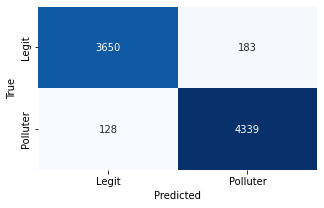

In [34]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
classes = ["Legit","Polluter"]
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')